10 Steps in a Machine Learning Project
1. Define the purpose of the ML project.

### Part 1. Finding a dataset

1. What format is the data in? Dates and numeric

2. Is the data clean? Yes, data downloaded from Yahoo! are cleaned.

3. How large is the dataset? Sizable data since 1980.

4. How will you split your data into train, validate and test sets? 60%, 20%, 20%

In [1]:
#!pip install yfinance
#!pip install tensorflow

In [2]:
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np
import pandas as pd
# import tensorflow as tf
import requests
import seaborn as sns
import time


from datetime import datetime, timedelta
# from bs4 import BeautifulSoup
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset


In [3]:
# help(yf.download)

For simplicity sake, we will be using Apple stock as the company has the highest market cap and also presents data since 1980.

In [4]:
aapl = yf.Ticker("AAPL")    
nasdaq = yf.Ticker("^IXIC")
sp500 = yf.Ticker("^GSPC")

In [5]:
# help(aapl.history(period=""))

In [6]:
nasdaq_price = nasdaq.history(period=None)
sp500_price = sp500.history(period=None)
aapl_price = aapl.history(period="120mo")

nasdaq_price = nasdaq_price.iloc[-len(aapl_price):,:]
sp500_price = sp500_price.iloc[-len(aapl_price):,:]
aapl_price.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-10-02 00:00:00-04:00,171.220001,174.300003,170.929993,173.750000,52164500,0.0,0.0
2023-10-03 00:00:00-04:00,172.259995,173.630005,170.820007,172.399994,49594600,0.0,0.0
2023-10-04 00:00:00-04:00,171.089996,174.210007,170.970001,173.660004,53020300,0.0,0.0
2023-10-05 00:00:00-04:00,173.789993,175.449997,172.679993,174.910004,48527900,0.0,0.0
2023-10-06 00:00:00-04:00,173.800003,177.990005,173.179993,177.490005,57224100,0.0,0.0


### Part 2. Exploratory Data Analysis (EDA)
1. Explore, clean and pre-process 
2. Dimension reduction & feature engineering

In [7]:
print(f'Total records are {aapl_price.shape[0]}. \nNull check \n{aapl_price.isnull().count()}')

Total records are 2518. 
Null check 
Open            2518
High            2518
Low             2518
Close           2518
Volume          2518
Dividends       2518
Stock Splits    2518
dtype: int64


In [8]:
# aapl_price = aapl_price.drop(columns=['Dividends',])

In [9]:
# aapl.news # Possible to explore corelation between news and price

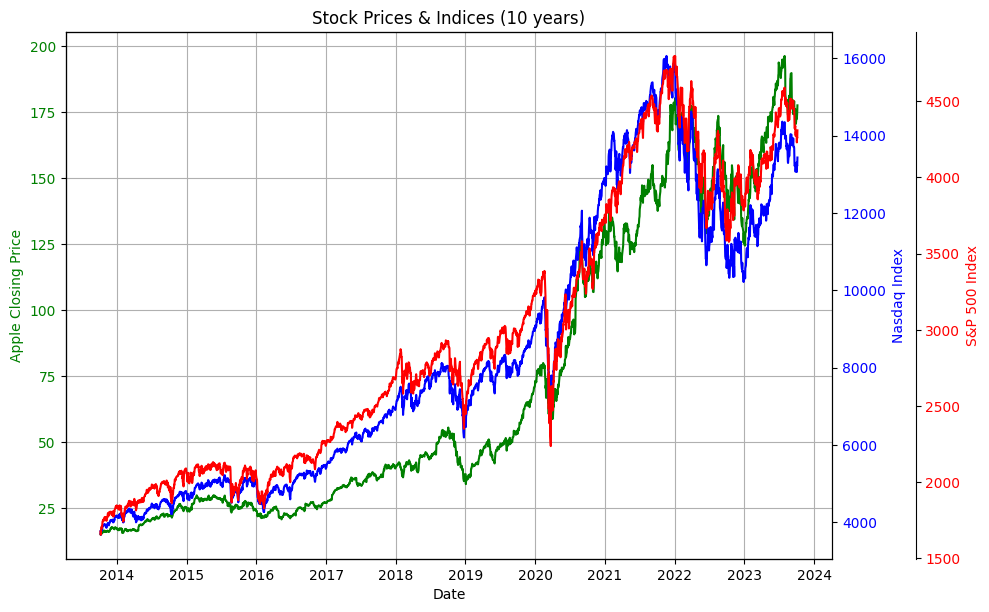

In [10]:
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(aapl_price['Close'], label='Apple Closing Price', color='g')
ax1.set_xlabel('Date')
ax1.set_ylabel('Apple Closing Price', color='g')
ax1.tick_params(axis='y', labelcolor='g')
ax1.grid(True)

ax2 = ax1.twinx()
ax2.plot(nasdaq_price['Close'], label='Nasdaq', color='b')
ax2.set_ylabel('Nasdaq Index', color='b')
ax2.tick_params(axis='y', labelcolor='b')

ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))
ax3.plot(sp500_price['Close'], label='S&P 500', color='r')
ax3.set_ylabel('S&P 500 Index', color='r')
ax3.tick_params(axis='y', labelcolor='r')

fig.tight_layout()
plt.title('Stock Prices & Indices (10 years)')
plt.show()

Other technical indicators and metrics that can help with prediction. 

1. Moving Average Convergence Divergence (MACD) - 
2. Relative Strength Index (RSI) - _Result of stock price_
3. On-Balance Volume (OBV) - _Perhaps doesn't align with short term strategy_
4. Chaikin Money Flow(CMF) - _Perhaps doesn't align with short term strategy_
5. Fibonacci Retracements
6. News Sentiment Analysis
7. and more...

A few consideration for the algorithm are.
1. Not to short a equity (or till model are in higher confidence) to limit potential losses.
2. RSI below 30 should trigger a higher aggressive technical
3. Crossover of MACD line should trigger a higher aggressive technical. Recommended to wait for 3-4 days to confirm __NOT__ a false positive
4. Fibonacci Retracements should support a slightly higher aggressive technical on each level. Most commonly used ratios include 23.6%, 38.2%, 50%, 61.8%, and 78.6

These pointers are what humans can observe. Using deep learning algorithms (RNN-LSTM), more pattern could potentially be uncovered.

In [11]:
#MACD with traditional setting (26/12/9). The signal line is a nine-period EMA of the MACD line.
def compute_macd(data, short_window=12, long_window=26, signal_window=9):
    short_ema = data['Close'].ewm(span=short_window, adjust=False).mean()
    long_ema = data['Close'].ewm(span=long_window, adjust=False).mean()
    
    # MACD line
    data['MACD'] = short_ema - long_ema
    
    # Signal Line
    data['Signal_Line'] = data['MACD'].ewm(span=signal_window, adjust=False).mean()

    return data

aapl_price = compute_macd(aapl_price)
aapl_price.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,MACD,Signal_Line
Date,,,,,,,,,
2013-10-07 00:00:00-04:00,15.165924,15.355746,15.128208,15.203015,312292400,0.0,0.0,0.000000,0.000000
2013-10-08 00:00:00-04:00,15.271273,15.293093,14.978279,14.990747,290917200,0.0,0.0,-0.016933,-0.003387
2013-10-09 00:00:00-04:00,15.106074,15.204258,14.907835,15.166855,301725200,0.0,0.0,-0.015958,-0.005901
2013-10-10 00:00:00-04:00,15.314290,15.347328,15.180882,15.261924,278602800,0.0,0.0,-0.007429,-0.006207
2013-10-11 00:00:00-04:00,15.179321,15.392833,15.122280,15.360728,267738800,0.0,0.0,0.007220,-0.003521


In [12]:
#RSI with Exponential Weighted Function(ewm) which give weights to values.
def compute_rsi(data, window):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)

    avg_gain = gain.ewm(min_periods=window, adjust=False, alpha=1/window).mean()
    avg_loss = loss.ewm(min_periods=window, adjust=False, alpha=1/window).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi

aapl_price['RSI'] = compute_rsi(aapl_price['Close'], 14)
aapl_price.head() # Notice the first 13 rows RSI are NaN due to calculation window

,Open,High,Low,Close,Volume,Dividends,Stock Splits,MACD,Signal_Line,RSI
Date,,,,,,,,,,
2013-10-07 00:00:00-04:00,15.165924,15.355746,15.128208,15.203015,312292400,0.0,0.0,0.000000,0.000000,NaN
2013-10-08 00:00:00-04:00,15.271273,15.293093,14.978279,14.990747,290917200,0.0,0.0,-0.016933,-0.003387,NaN
2013-10-09 00:00:00-04:00,15.106074,15.204258,14.907835,15.166855,301725200,0.0,0.0,-0.015958,-0.005901,NaN
2013-10-10 00:00:00-04:00,15.314290,15.347328,15.180882,15.261924,278602800,0.0,0.0,-0.007429,-0.006207,NaN
2013-10-11 00:00:00-04:00,15.179321,15.392833,15.122280,15.360728,267738800,0.0,0.0,0.007220,-0.003521,NaN


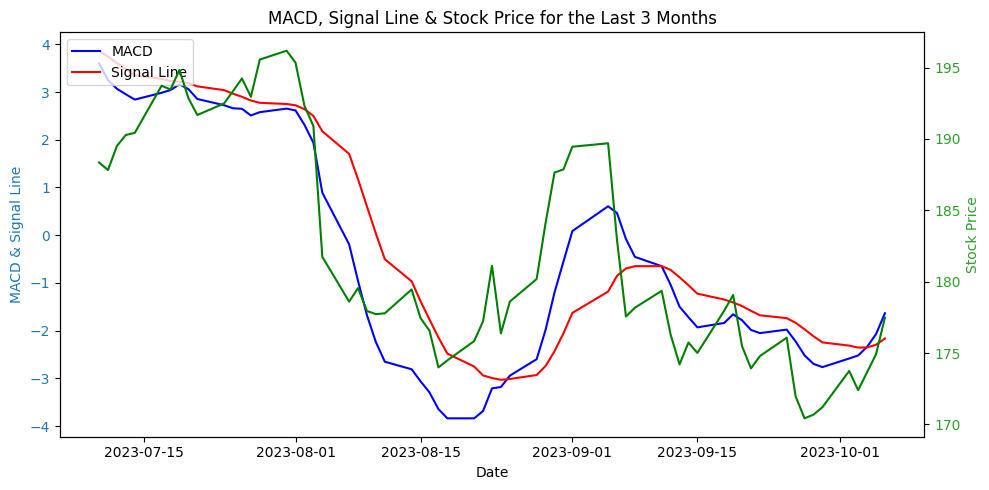

In [13]:
# 3 months period plot
# Plotting MACD and stock price
end_date = aapl_price.index[-1]  # Get the last date
start_date = end_date - timedelta(days=90)  # approx. 3 months

filtered_data = aapl_price[start_date:end_date]

fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.set_xlabel('Date')
ax1.set_ylabel('MACD & Signal Line', color='tab:blue')
ax1.plot(filtered_data.index, filtered_data['MACD'], label='MACD', color='blue')
ax1.plot(filtered_data.index, filtered_data['Signal_Line'], label='Signal Line', color='red')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()  
ax2.set_ylabel('Stock Price', color='tab:green')  
ax2.plot(filtered_data.index, filtered_data['Close'], label='Stock Price', color='green')
ax2.tick_params(axis='y', labelcolor='tab:green')

plt.title('MACD, Signal Line & Stock Price for the Last 3 Months')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if needed
fig.tight_layout()  
plt.show()

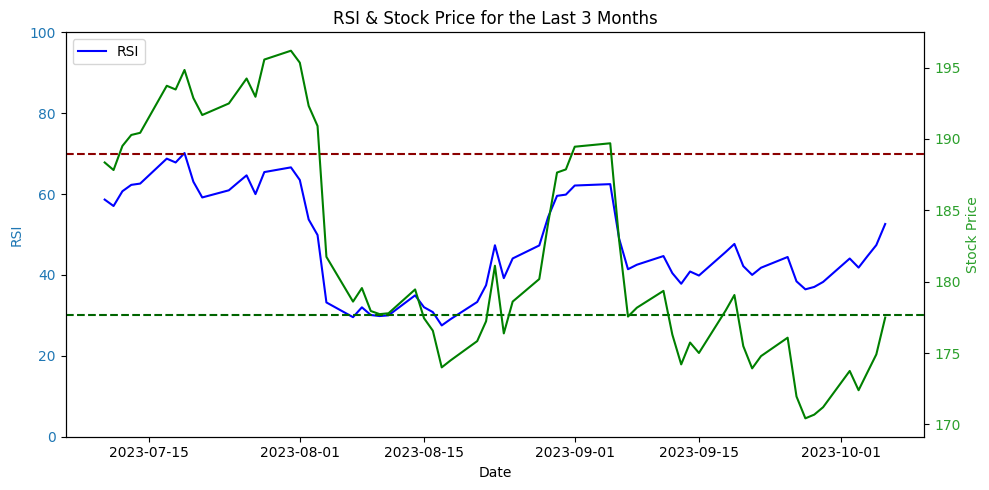

In [14]:
# Plotting RSI and stock price
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.set_xlabel('Date')
ax1.set_ylabel('RSI', color='tab:blue')
ax1.plot(filtered_data.index, filtered_data['RSI'], label='RSI', color='blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_ylim(0, 100)
ax1.legend(loc='upper left')
ax1.axhline(y=70, color='darkred', linestyle='--')  # Overbought level
ax1.axhline(y=30, color='darkgreen', linestyle='--')  # Oversold level

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Stock Price', color='tab:green')  # we already handled the x-label with ax1
ax2.plot(filtered_data.index, filtered_data['Close'], label='Stock Price', color='green')
ax2.tick_params(axis='y', labelcolor='tab:green')

plt.title('RSI & Stock Price for the Last 3 Months')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if needed
fig.tight_layout()  # Adjust subplot parameters to give specified padding
plt.show()

In [15]:
print(f'Total records are {aapl_price.shape[0]}. \nNull check \n{aapl_price.isnull().sum()}')

Total records are 2518. 
Null check 
Open             0
High             0
Low              0
Close            0
Volume           0
Dividends        0
Stock Splits     0
MACD             0
Signal_Line      0
RSI             13
dtype: int64


In [16]:
correlation_matrix = aapl_price.corr()
correlation_matrix

,Open,High,Low,Close,Volume,Dividends,Stock Splits,MACD,Signal_Line,RSI
Open,1.000000,0.999877,0.999851,0.999688,-0.489633,0.027527,-0.006657,0.204768,0.223815,-0.032844
High,0.999877,1.000000,0.999822,0.999852,-0.487259,0.026864,-0.006290,0.202694,0.221322,-0.032867
Low,0.999851,0.999822,1.000000,0.999858,-0.492850,0.027198,-0.006704,0.207400,0.225243,-0.028016
Close,0.999688,0.999852,0.999858,1.000000,-0.490290,0.027182,-0.006350,0.205240,0.222721,-0.027964
Volume,-0.489633,-0.487259,-0.492850,-0.490290,1.000000,-0.030887,0.040292,-0.139099,-0.130682,-0.131962
Dividends,0.027527,0.026864,0.027198,0.027182,-0.030887,1.000000,-0.003361,0.029853,0.028621,0.008148
Stock Splits,-0.006657,-0.006290,-0.006704,-0.006350,0.040292,-0.003361,1.000000,0.038222,0.037597,0.050864
MACD,0.204768,0.202694,0.207400,0.205240,-0.139099,0.029853,0.038222,1.000000,0.951749,0.624583
Signal_Line,0.223815,0.221322,0.225243,0.222721,-0.130682,0.028621,0.037597,0.951749,1.000000,0.512421
RSI,-0.032844,-0.032867,-0.028016,-0.027964,-0.131962,0.008148,0.050864,0.624583,0.512421,1.000000


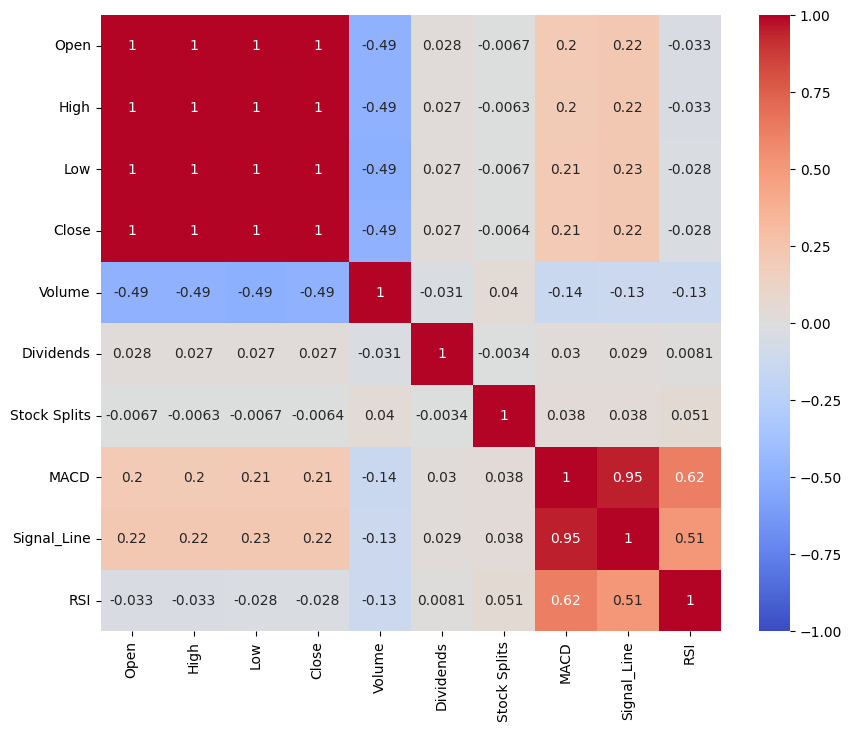

In [17]:
# Using Seaborn to plot a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

Some NaN values on RSI column due to calculation. 
Methods of dealing with null cells.
1. Delete row.
2. Fill with mean value
3. Use expert opinion.

We can remove irrelevant columns or too highly correlated columns too. 

#### Decision to delete row since Null rows represents a small portion of training data. 

In [18]:
aapl_price = aapl_price.dropna().drop(columns=['Open','High','Low','Dividends','Stock Splits','MACD','RSI'])
print(f'Total records are {aapl_price.shape[0]}. \nNull check \n{aapl_price.isnull().sum()}')

Total records are 2505. 
Null check 
Close          0
Volume         0
Signal_Line    0
dtype: int64


### Part 3. ML techniques and data partition
Recurrent Neural Networks (RNNs) are designed to handle sequences of variable lengths, making them particularly suitable for tasks like predicting future values in a sequence. They maintain an internal state that can capture information about previous elements in the sequence, allowing them to remember important parts and potentially forget less crucial details over time.


However, traditional RNNs suffer from challenges related to the vanishing and exploding gradient problems, especially when processing long sequences. These issues hinder RNN’s ability to learn from distant past information in the sequence.


To address this, __Long Short-Term Memory (LSTM)__ networks were introduced. LSTMs are a special kind of RNN that can learn and remember over long sequences and are not as susceptible to the vanishing gradient problem as standard RNNs. This makes them more efficient at capturing long-term dependencies in sequence data.

Allocation of data for training are
1. Train: 60%
2. Validation: 20% 
3. Test: 20%

Project is a regression problem, hence we will be testing out 2 performance metrics.
1. Mean Square Error (MSE)
2. Mean Absolute Error (MAE)


In [19]:
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 1 - train_ratio - val_ratio

# We dont use max/min scaling for possible new highs/lows
scaler = StandardScaler()

# Splitting the data
train, temp = train_test_split(aapl_price, test_size=1-train_ratio, shuffle=False)
val, test = train_test_split(temp, test_size=test_ratio/(test_ratio + val_ratio), shuffle=False)

scaler.fit(train)  # Only fit on training data
train_scaled = pd.DataFrame(scaler.transform(train), columns=train.columns, index=train.index)
val_scaled = pd.DataFrame(scaler.transform(val), columns=val.columns, index=val.index)
test_scaled = pd.DataFrame(scaler.transform(test), columns=test.columns, index=test.index)

aapl_price.shape, train_scaled.shape, val_scaled.shape, test_scaled.shape

((2505, 3), (1503, 3), (501, 3), (501, 3))

In [20]:
train_scaled.describe()

,Close,Volume,Signal_Line
count,1.503000e+03,1.503000e+03,1.503000e+03
mean,-1.512799e-16,-7.563995e-17,9.454993e-18
std,1.000333e+00,1.000333e+00,1.000333e+00
min,-1.536223e+00,-1.292409e+00,-4.105047e+00
25%,-7.673589e-01,-6.835516e-01,-4.071590e-01
50%,-3.398392e-01,-2.789672e-01,8.958665e-02
75%,8.328058e-01,3.989873e-01,5.805522e-01
max,2.351657e+00,9.394099e+00,2.378778e+00


Pytorch

In [21]:
class CustomDataset(Dataset):
    def __init__(self, data, target_column, sequence_length):
        self.data = data.drop(columns=[target_column]).values
        self.targets = data[target_column].values
        self.sequence_length = sequence_length

    def __len__(self):
        # Adjust the length to account for sequences
        return len(self.data) - self.sequence_length + 1

    def __getitem__(self, idx):
        # Fetch a sequence of data
        x = self.data[idx:idx+self.sequence_length]
        # The target is the `Close` price of the day after the sequence
        y = self.targets[idx+self.sequence_length-1]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

In [22]:
sequence_length = 10  # Use 10 previous days to predict the next day's Close price
batch_size = 64

train_dataset = CustomDataset(train_scaled, target_column='Close', sequence_length=sequence_length)
val_dataset = CustomDataset(val_scaled, target_column='Close', sequence_length=sequence_length)
test_dataset = CustomDataset(test_scaled, target_column='Close', sequence_length=sequence_length)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [23]:
def train(train_loader, model, optimizer, criterion):
    running_loss = 0

    for batch in train_loader:
        inputs, targets = batch
        optimizer.zero_grad()  # Zero out any gradients
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets.view(-1, 1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)


def validation(data_loader, model, criterion):
    total_val_loss = 0

    with torch.no_grad():
        for batch in val_loader:
            inputs, targets = batch
            outputs = model(inputs)
            loss = criterion(outputs, targets.view(-1, 1))
            total_val_loss += loss.item()
    
    return total_val_loss / len(val_loader)

def test(test_loader, model):
# Test the model on the test dataset
    model.eval()
    all_test_predictions = []  # List to collect all predictions during testing
    all_test_targets = []  # List to collect all true targets during testing

    with torch.no_grad():
        for batch in test_loader:
            inputs, targets = batch
            outputs = model(inputs)

            # Collecting predictions and targets for unscaling later
            all_test_predictions.extend(outputs.cpu().numpy().flatten())
            all_test_targets.extend(targets.cpu().numpy().flatten())

#     # Convert the lists of predictions and targets to numpy arrays
    all_test_predictions = np.array(all_test_predictions)
    all_test_targets = np.array(all_test_targets)

    close_scale = scaler.scale_[0]
    close_mean = scaler.mean_[0]

    # Unscale the predictions and targets
    unscaled_test_predictions = all_test_predictions * close_scale + close_mean
    unscaled_test_targets = all_test_targets * close_scale + close_mean
    return(unscaled_test_targets, unscaled_test_predictions)# unscaled_test_targets, unscaled_test_predictions)

Epoch [100/300], Loss: 0.14
Validation Loss: 36.37
Epoch [200/300], Loss: 0.03
Validation Loss: 37.65
Epoch [300/300], Loss: 0.01
Validation Loss: 37.99
Training completed in 96.72 seconds


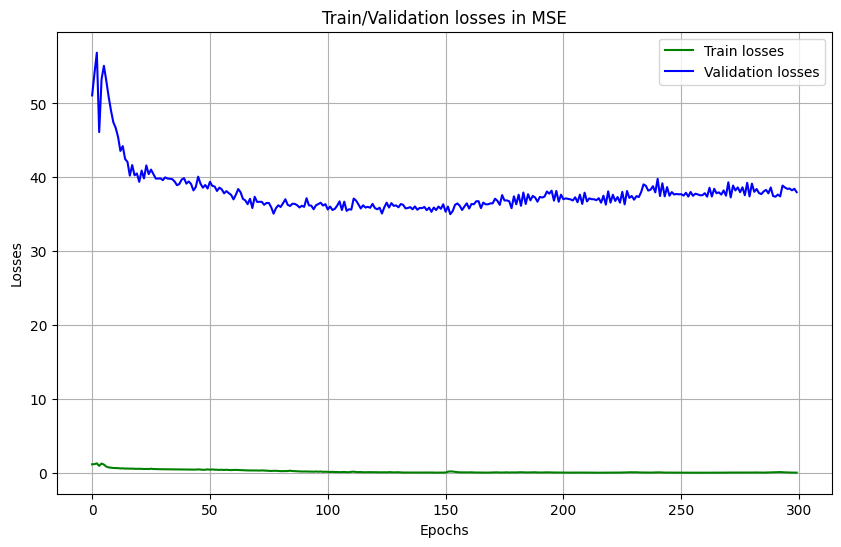

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class StockLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout, output_dim=1):
        super(StockLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, (hn, cn) = self.lstm(x)
        out = self.linear(out[:, -1, :])
        return out

# Hyperparameters
def main(train_loader, val_loader, test_loader, bo):
    input_dim = 2  # ['Close', 'Volume', 'Signal_Line']
    output_dim = 1 # Prediction 'Close'
    
    #For bo hidden_dim, num_layers, dropout, learning_rate
    hidden_dim = int(bo[0])
    num_layers = int(bo[1])
    dropout = float(bo[2])
    learning_rate = float(bo[3])
    
    model = StockLSTM(input_dim, hidden_dim, num_layers, dropout, output_dim)

    # Loss and optimizer
    criterion = torch.nn.MSELoss()  # For regression tasks
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    num_epochs = 300
    val_score = []
    train_score = []
    start = time.time()
    for epoch in range(num_epochs):
        train_loss = train(train_loader, model, optimizer, criterion) # Call train function
        train_score.append(train_loss)

        if (epoch+1) % 100 ==0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.2f}")

        # Validation 
        model.eval()
        val_loss = validation(val_loader, model, criterion) # Call val function
        val_score.append(val_loss)
        if (epoch+1) % 100 ==0:
            print(f"Validation Loss: {val_loss:.2f}")

    end = time.time()
    print(f"Training completed in {end-start:.2f} seconds")
    
    #Train vs Val loss (MSE) plot
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(train_score, label='Train losses', color='g')
    ax.plot(val_score, label='Validation losses', color='b')
    ax.set_xlabel('Epochs')  # Assuming x-axis represents epochs
    ax.set_ylabel('Losses')
    ax.legend()  # To show the labels in a legend
    ax.grid(True)
    plt.title('Train/Validation losses in MSE')
    plt.show()
    
    unscaled_test_targets, unscaled_test_predictions = test(test_loader, model)
    return(unscaled_test_targets, unscaled_test_predictions, train_score, val_score)
    
if __name__ == '__main__':
    bo = [50, 2, 0.5, 0.01] # Call BO.
    unscaled_test_targets, unscaled_test_predictions, train_score, val_score = main(train_loader, val_loader, test_loader, bo) 

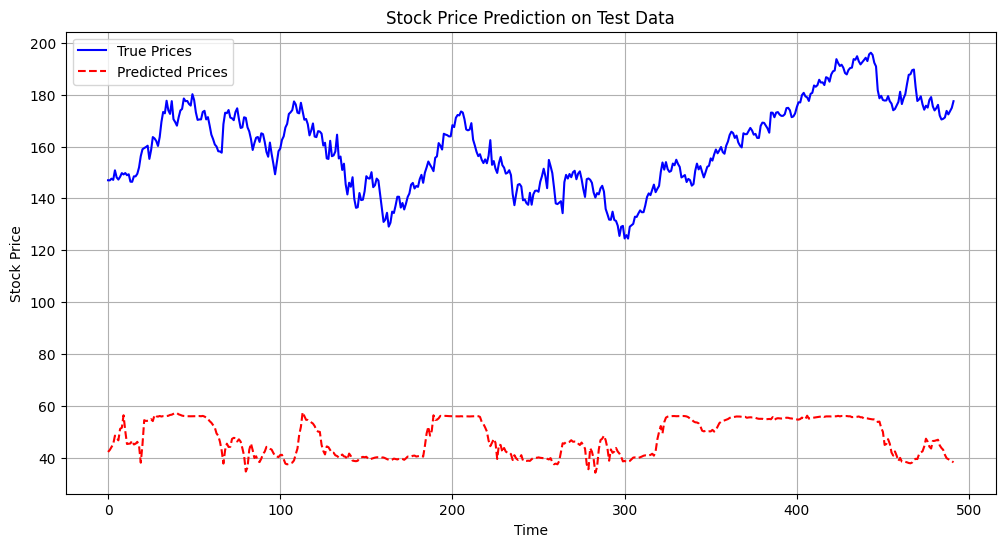

In [25]:
plt.figure(figsize=(12, 6))
plt.plot(unscaled_test_targets, label='True Prices', color='blue')
plt.plot(unscaled_test_predictions, label='Predicted Prices', color='red', linestyle='dashed')

plt.title('Stock Price Prediction on Test Data')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

### Part 3. Hyperparameter Optimization

From the plot above, we can observe that the prediction is pretty bad. Options is to try to tune the parameters to see if plots can get closer to the actual test. 

From the high validation loss, we can conclude that the the model is overfitting.

Bayesian Optimization



In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statistics import NormalDist
from scipy.stats import norm
from sklearn.decomposition import KernelPCA, PCA

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF 

In [27]:
bo_train_score = pd.DataFrame(train_score)
bo_val_score = pd.DataFrame(val_score)
score = abs(bo_train_score - bo_val_score)
min_score = score.min()
X = np.array(bo)
Y = np.array(min_score) # val_loss # Validation loss
X = X.reshape(1, -1)  
Y = Y.reshape(-1, 1)  
print(X.shape,Y.shape)

(1, 4) (1, 1)


In [28]:
def probability_improvement(eta):
    #For bo hidden_dim, num_layers, dropout, learning_rate
    query_range1 = np.linspace(50, 300, 51)  # For the first and second features
    query_range2 = np.linspace(2, 30, 15)  # For the first and second features    
    query_range3 = np.linspace(0.001, 0.999, 20)    # For the third and fourth features

    # Construct meshgrid using individual feature ranges
    grid = np.meshgrid(query_range1, query_range2, query_range3, query_range3)
    query_points = np.vstack(list(map(np.ravel, grid))).T

    
    mean, std = bogp.predict(query_points, return_std=True)
    best_observed = np.min(df_y) #.max(df_y) 
    
    pi = []
    for k in range(len(query_points)):
        pi.append(1 - NormalDist(mu = mean[k], sigma = std[k]).cdf(best_observed - eta))
        
    pi = np.array(pi)
    next_query_point = query_points[np.argmin(pi)] #[np.argmax(pi)]
    
    return query_points, pi 

In [29]:
def upper_confidence_bound(beta): #UCB
    #For bo hidden_dim, num_layers, dropout, learning_rate
    query_range1 = np.linspace(50, 300, 51)  # For the first and second features
    query_range2 = np.linspace(2, 30, 15)  # For the first and second features    
    query_range3 = np.linspace(0.001, 0.999, 20)    # For the third and fourth features

    # Construct meshgrid using individual feature ranges
    grid = np.meshgrid(query_range1, query_range2, query_range3, query_range3)
    query_points = np.vstack(list(map(np.ravel, grid))).T

    
    mean, std = bogp.predict(query_points, return_std=True)
    ucb = mean - (beta * std)
    
    next_query_point = query_points[np.argmin(ucb)] # [np.argmax(ucb)]
    
    return query_points, ucb 

In [30]:
def expected_improvement(xi):
    #For bo hidden_dim, num_layers, dropout, learning_rate
    query_range1 = np.linspace(50, 300, 51)  # For the first and second features
    query_range2 = np.linspace(2, 30, 15)  # For the first and second features    
    query_range3 = np.linspace(0.001, 0.999, 20)    # For the third and fourth features

    # Construct meshgrid using individual feature ranges
    grid = np.meshgrid(query_range1, query_range2, query_range3, query_range3)
    query_points = np.vstack(list(map(np.ravel, grid))).T
    
    f_best = np.min(df_y)
    mean, std = bogp.predict(query_points, return_std=True)
    
    z = (f_best - mean - xi) / std #    z = (mean - f_best - xi) / std
    ei = (f_best - mean - xi) * norm.cdf(z) - std * norm.pdf(z)# ei = (mean - f_best - xi) * norm.cdf(z) + std * norm.pdf(z)
    ei[std == 0.0] = 0.0  # Set EI to 0 where std is 0 to avoid division by zero.

    next_query_point = query_points[np.argmax(ei)] # This is correct

    return query_points, ei 

In [31]:
def update_surrogate_model(new_X, new_y):
    if len(X) == 0 and len(Y) == 0:
        # If X and Y are empty, just return the new_X and new_y
        return new_X, new_y

    # Stack them vertically
    df_X = np.vstack([X, new_X])
    df_y = np.vstack([Y, new_y])
    return df_X, df_y

In [32]:
def choose_next_query_point(next_query_point_ucb, af_ucb, next_query_point_ei, af_ei, next_query_point_pi, af_pi):
    
    # Find the index of the element with the highest acquisition function value for each method
    min_ucb_index = np.argmin(af_ucb)
    min_pi_index = np.argmin(af_pi)
    max_ei_index = np.argmax(af_ei)

    # Get the corresponding query points with the highest acquisition function values
    next_query_point_min_ucb = next_query_point_ucb[min_ucb_index]
    next_query_point_max_ei = next_query_point_ei[max_ei_index]
    next_query_point_min_pi = next_query_point_pi[min_pi_index]


    # Compare the acquisition function values and choose the highest
    if af_ucb[min_ucb_index] <= af_ei[max_ei_index] and af_ucb[min_ucb_index] <= af_pi[min_pi_index]:
        return next_query_point_min_ucb, 'UCB'
    
    elif af_ei[max_ei_index] >= af_ucb[min_ucb_index] and af_ei[max_ei_index] >= af_pi[min_pi_index]:
        return next_query_point_max_ei, 'Expected Improvement'
    
    else:
        return next_query_point_min_pi, 'Probability of Improvement'


In [33]:
query = np.empty((0, len(X[0])))  # Assuming X is a 2D array
obs = np.empty((0, 1))  # 1D column vector

Next suggested query point by UCB: 55.000-2.000-0.001-0.001
[[5.e+01 2.e+00 5.e-01 1.e-02]] [[34.81696765]]
Epoch [100/300], Loss: 0.42
Validation Loss: 40.34
Epoch [200/300], Loss: 0.23
Validation Loss: 35.43
Epoch [300/300], Loss: 0.10
Validation Loss: 34.76
Training completed in 105.51 seconds


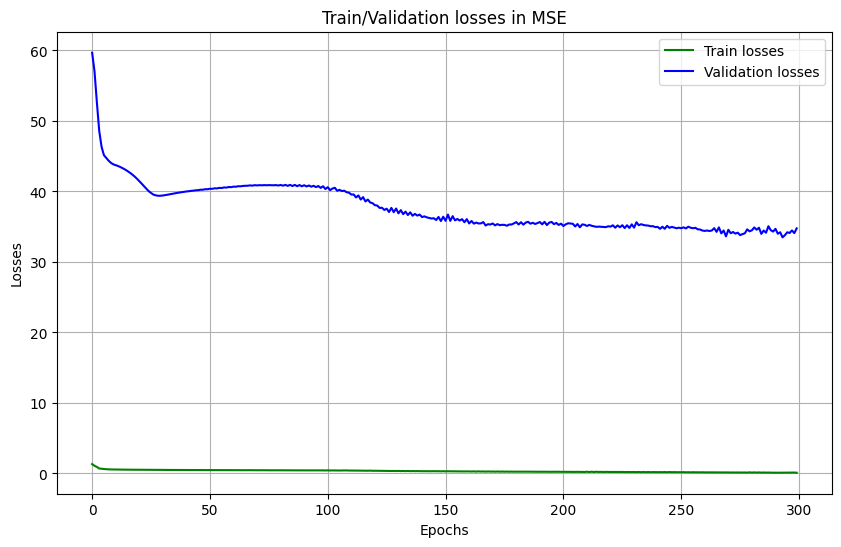

BO is [[5.5e+01 2.0e+00 1.0e-03 1.0e-03]], with validation loss of [33.37847899]
Next suggested query point by UCB: 60.000-2.000-0.001-0.001
[[5.0e+01 2.0e+00 5.0e-01 1.0e-02]
 [5.5e+01 2.0e+00 1.0e-03 1.0e-03]] [[34.81696765]
 [33.37847899]]
Epoch [100/300], Loss: 0.43
Validation Loss: 40.32
Epoch [200/300], Loss: 0.23
Validation Loss: 35.76
Epoch [300/300], Loss: 0.06
Validation Loss: 34.04
Training completed in 105.69 seconds


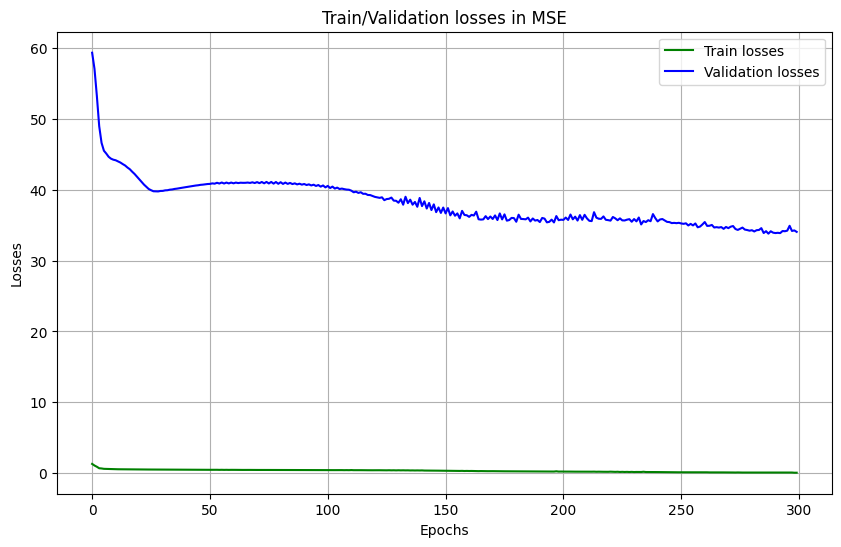

BO is [[6.e+01 2.e+00 1.e-03 1.e-03]], with validation loss of [33.71310823]
Next suggested query point by UCB: 130.000-2.000-0.001-0.001
[[5.0e+01 2.0e+00 5.0e-01 1.0e-02]
 [5.5e+01 2.0e+00 1.0e-03 1.0e-03]
 [6.0e+01 2.0e+00 1.0e-03 1.0e-03]] [[34.81696765]
 [33.37847899]
 [33.71310823]]
Epoch [100/300], Loss: 0.38
Validation Loss: 37.85
Epoch [200/300], Loss: 0.09
Validation Loss: 34.56
Epoch [300/300], Loss: 0.02
Validation Loss: 37.15
Training completed in 188.18 seconds


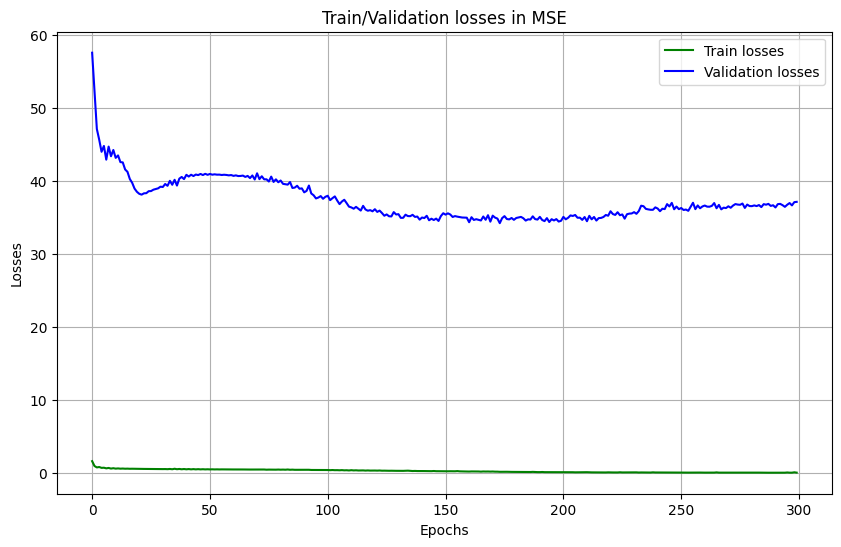

BO is [[1.3e+02 2.0e+00 1.0e-03 1.0e-03]], with validation loss of [34.09909478]
Next suggested query point by UCB: 200.000-2.000-0.001-0.001
[[5.0e+01 2.0e+00 5.0e-01 1.0e-02]
 [5.5e+01 2.0e+00 1.0e-03 1.0e-03]
 [6.0e+01 2.0e+00 1.0e-03 1.0e-03]
 [1.3e+02 2.0e+00 1.0e-03 1.0e-03]] [[34.81696765]
 [33.37847899]
 [33.71310823]
 [34.09909478]]
Epoch [100/300], Loss: 0.37
Validation Loss: 37.09
Epoch [200/300], Loss: 0.07
Validation Loss: 36.26
Epoch [300/300], Loss: 0.01
Validation Loss: 36.67
Training completed in 290.34 seconds


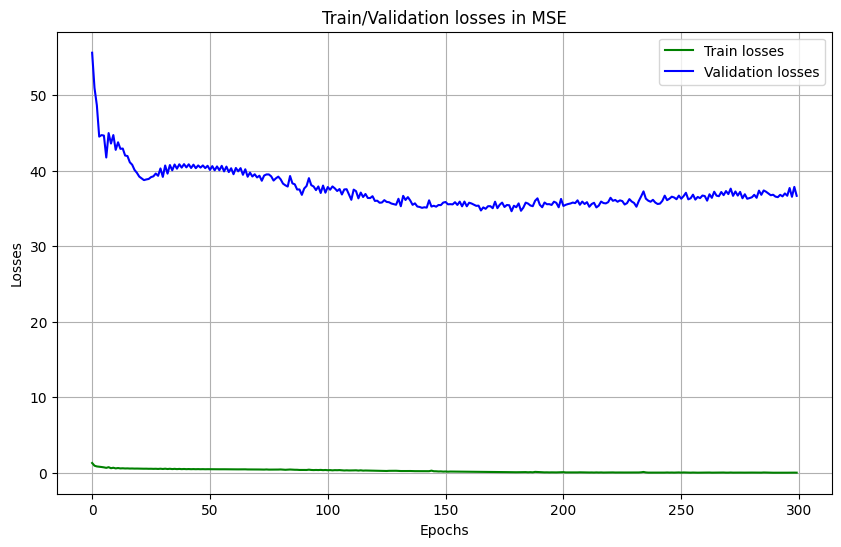

BO is [[2.e+02 2.e+00 1.e-03 1.e-03]], with validation loss of [34.55456865]
Next suggested query point by UCB: 270.000-2.000-0.001-0.001
[[5.0e+01 2.0e+00 5.0e-01 1.0e-02]
 [5.5e+01 2.0e+00 1.0e-03 1.0e-03]
 [6.0e+01 2.0e+00 1.0e-03 1.0e-03]
 [1.3e+02 2.0e+00 1.0e-03 1.0e-03]
 [2.0e+02 2.0e+00 1.0e-03 1.0e-03]] [[34.81696765]
 [33.37847899]
 [33.71310823]
 [34.09909478]
 [34.55456865]]
Epoch [100/300], Loss: 0.41
Validation Loss: 37.87
Epoch [200/300], Loss: 0.04
Validation Loss: 35.63
Epoch [300/300], Loss: 0.01
Validation Loss: 37.70
Training completed in 505.38 seconds


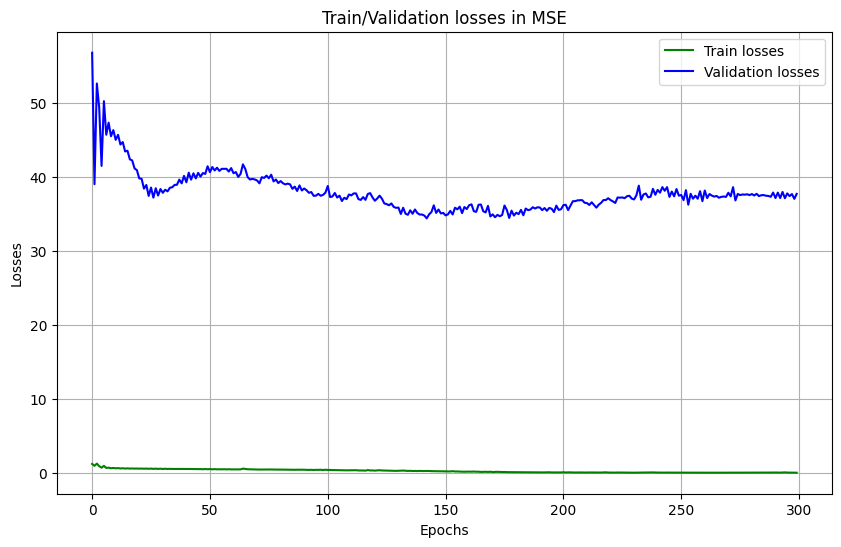

BO is [[2.7e+02 2.0e+00 1.0e-03 1.0e-03]], with validation loss of [34.1593104]
Next suggested query point by UCB: 165.000-30.000-0.999-0.999
[[5.0e+01 2.0e+00 5.0e-01 1.0e-02]
 [5.5e+01 2.0e+00 1.0e-03 1.0e-03]
 [6.0e+01 2.0e+00 1.0e-03 1.0e-03]
 [1.3e+02 2.0e+00 1.0e-03 1.0e-03]
 [2.0e+02 2.0e+00 1.0e-03 1.0e-03]
 [2.7e+02 2.0e+00 1.0e-03 1.0e-03]] [[34.81696765]
 [33.37847899]
 [33.71310823]
 [34.09909478]
 [34.55456865]
 [34.1593104 ]]
Epoch [100/300], Loss: 119.40
Validation Loss: 126.38
Epoch [200/300], Loss: 118.95
Validation Loss: 126.22
Epoch [300/300], Loss: 118.91
Validation Loss: 126.24
Training completed in 13316.35 seconds


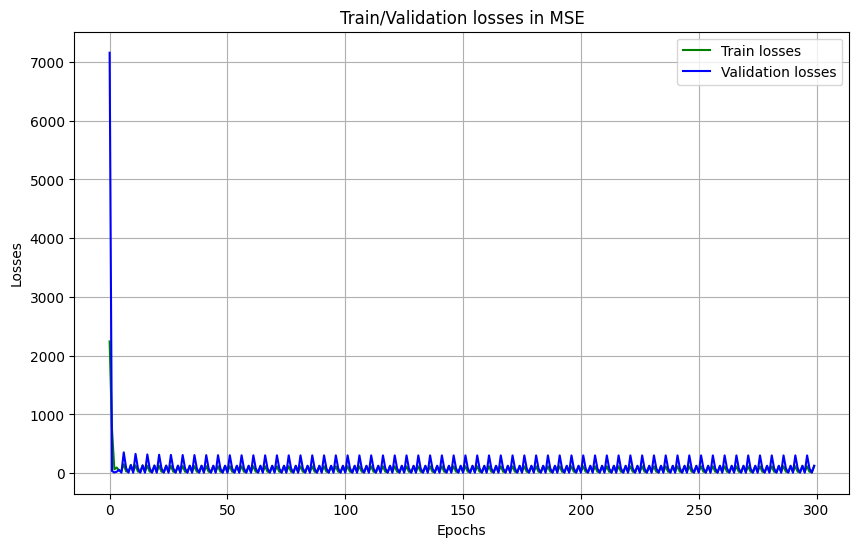

BO is [[165.     30.      0.999   0.999]], with validation loss of [0.22893775]
Next suggested query point by UCB: 65.000-2.000-0.001-0.001
[[5.00e+01 2.00e+00 5.00e-01 1.00e-02]
 [5.50e+01 2.00e+00 1.00e-03 1.00e-03]
 [6.00e+01 2.00e+00 1.00e-03 1.00e-03]
 [1.30e+02 2.00e+00 1.00e-03 1.00e-03]
 [2.00e+02 2.00e+00 1.00e-03 1.00e-03]
 [2.70e+02 2.00e+00 1.00e-03 1.00e-03]
 [1.65e+02 3.00e+01 9.99e-01 9.99e-01]] [[34.81696765]
 [33.37847899]
 [33.71310823]
 [34.09909478]
 [34.55456865]
 [34.1593104 ]
 [ 0.22893775]]
Epoch [100/300], Loss: 0.43
Validation Loss: 40.54
Epoch [200/300], Loss: 0.23
Validation Loss: 35.68
Epoch [300/300], Loss: 0.06
Validation Loss: 36.00
Training completed in 123.90 seconds


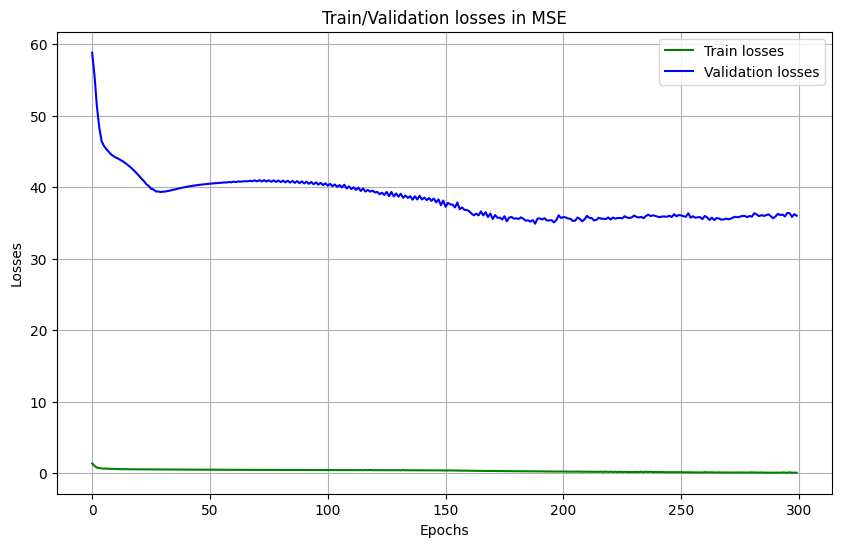

BO is [[6.5e+01 2.0e+00 1.0e-03 1.0e-03]], with validation loss of [34.64108571]
Next suggested query point by UCB: 235.000-30.000-0.999-0.999
[[5.00e+01 2.00e+00 5.00e-01 1.00e-02]
 [5.50e+01 2.00e+00 1.00e-03 1.00e-03]
 [6.00e+01 2.00e+00 1.00e-03 1.00e-03]
 [1.30e+02 2.00e+00 1.00e-03 1.00e-03]
 [2.00e+02 2.00e+00 1.00e-03 1.00e-03]
 [2.70e+02 2.00e+00 1.00e-03 1.00e-03]
 [1.65e+02 3.00e+01 9.99e-01 9.99e-01]
 [6.50e+01 2.00e+00 1.00e-03 1.00e-03]] [[34.81696765]
 [33.37847899]
 [33.71310823]
 [34.09909478]
 [34.55456865]
 [34.1593104 ]
 [ 0.22893775]
 [34.64108571]]
Epoch [100/300], Loss: 36.88
Validation Loss: 378.53
Epoch [200/300], Loss: 36.72
Validation Loss: 377.71
Epoch [300/300], Loss: 36.71
Validation Loss: 377.73
Training completed in 24371.21 seconds


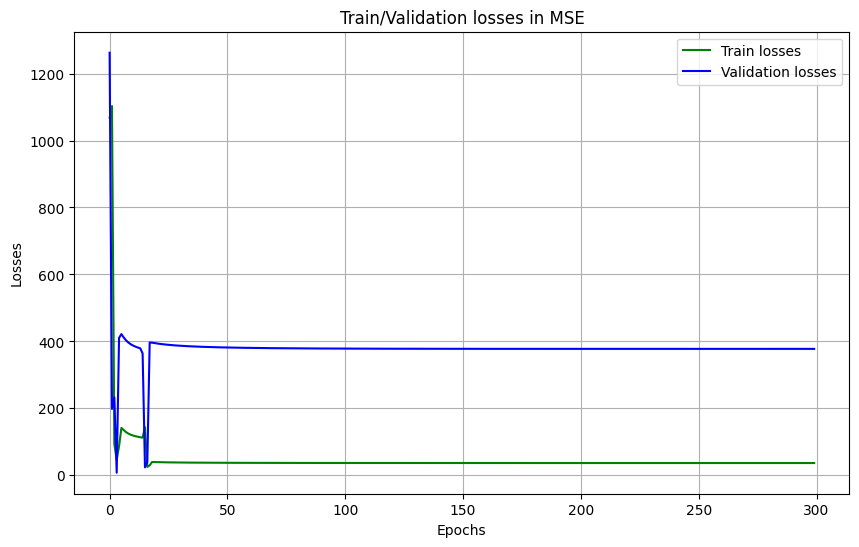

BO is [[235.     30.      0.999   0.999]], with validation loss of [15.05886805]
Next suggested query point by UCB: 75.000-2.000-0.001-0.001
[[5.00e+01 2.00e+00 5.00e-01 1.00e-02]
 [5.50e+01 2.00e+00 1.00e-03 1.00e-03]
 [6.00e+01 2.00e+00 1.00e-03 1.00e-03]
 [1.30e+02 2.00e+00 1.00e-03 1.00e-03]
 [2.00e+02 2.00e+00 1.00e-03 1.00e-03]
 [2.70e+02 2.00e+00 1.00e-03 1.00e-03]
 [1.65e+02 3.00e+01 9.99e-01 9.99e-01]
 [6.50e+01 2.00e+00 1.00e-03 1.00e-03]
 [2.35e+02 3.00e+01 9.99e-01 9.99e-01]] [[34.81696765]
 [33.37847899]
 [33.71310823]
 [34.09909478]
 [34.55456865]
 [34.1593104 ]
 [ 0.22893775]
 [34.64108571]
 [15.05886805]]
Epoch [100/300], Loss: 0.41
Validation Loss: 39.37
Epoch [200/300], Loss: 0.20
Validation Loss: 35.83
Epoch [300/300], Loss: 0.05
Validation Loss: 35.71
Training completed in 120.87 seconds


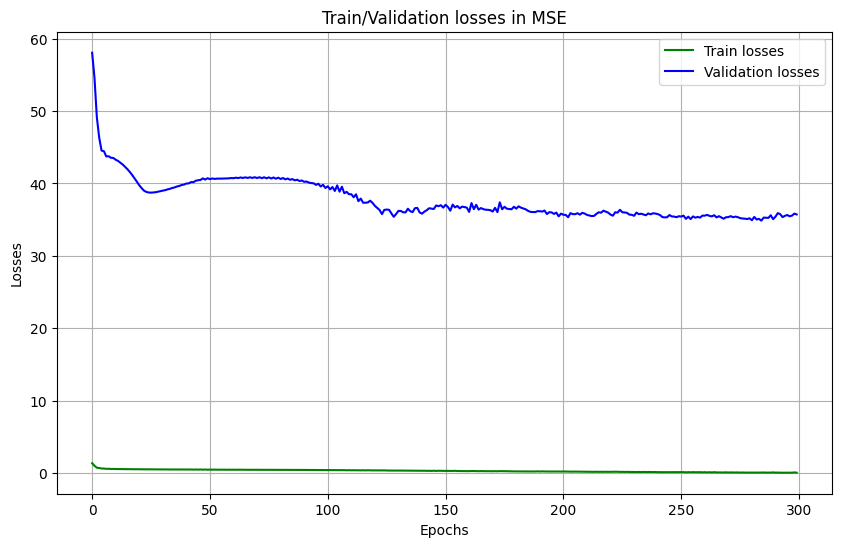

BO is [[7.5e+01 2.0e+00 1.0e-03 1.0e-03]], with validation loss of [34.78877624]
Next suggested query point by UCB: 300.000-30.000-0.999-0.999
[[5.00e+01 2.00e+00 5.00e-01 1.00e-02]
 [5.50e+01 2.00e+00 1.00e-03 1.00e-03]
 [6.00e+01 2.00e+00 1.00e-03 1.00e-03]
 [1.30e+02 2.00e+00 1.00e-03 1.00e-03]
 [2.00e+02 2.00e+00 1.00e-03 1.00e-03]
 [2.70e+02 2.00e+00 1.00e-03 1.00e-03]
 [1.65e+02 3.00e+01 9.99e-01 9.99e-01]
 [6.50e+01 2.00e+00 1.00e-03 1.00e-03]
 [2.35e+02 3.00e+01 9.99e-01 9.99e-01]
 [7.50e+01 2.00e+00 1.00e-03 1.00e-03]] [[34.81696765]
 [33.37847899]
 [33.71310823]
 [34.09909478]
 [34.55456865]
 [34.1593104 ]
 [ 0.22893775]
 [34.64108571]
 [15.05886805]
 [34.78877624]]
Epoch [100/300], Loss: 193.63
Validation Loss: 48.50
Epoch [200/300], Loss: 192.95
Validation Loss: 48.26
Epoch [300/300], Loss: 192.90
Validation Loss: 48.25
Training completed in 25271.52 seconds


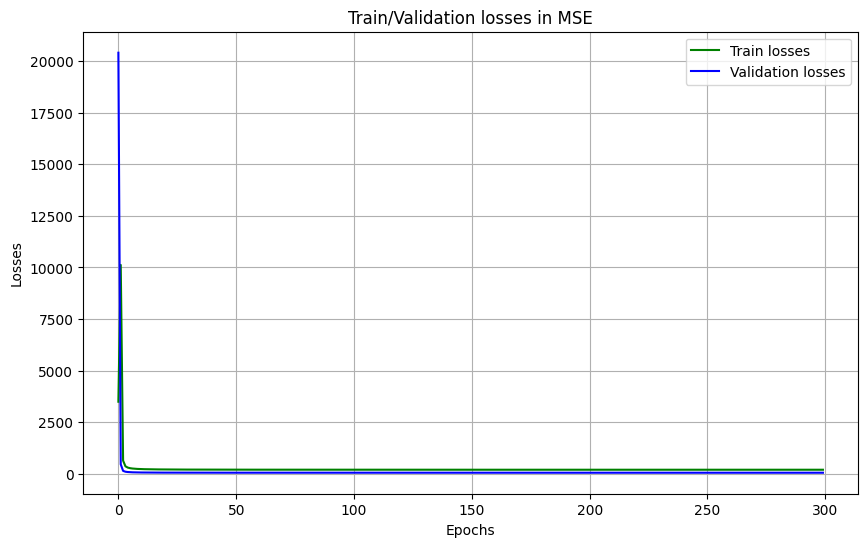

BO is [[300.     30.      0.999   0.999]], with validation loss of [144.65054798]
Next suggested query point by Probability of Improvement: 165.000-30.000-0.001-0.001
[[5.00e+01 2.00e+00 5.00e-01 1.00e-02]
 [5.50e+01 2.00e+00 1.00e-03 1.00e-03]
 [6.00e+01 2.00e+00 1.00e-03 1.00e-03]
 [1.30e+02 2.00e+00 1.00e-03 1.00e-03]
 [2.00e+02 2.00e+00 1.00e-03 1.00e-03]
 [2.70e+02 2.00e+00 1.00e-03 1.00e-03]
 [1.65e+02 3.00e+01 9.99e-01 9.99e-01]
 [6.50e+01 2.00e+00 1.00e-03 1.00e-03]
 [2.35e+02 3.00e+01 9.99e-01 9.99e-01]
 [7.50e+01 2.00e+00 1.00e-03 1.00e-03]
 [3.00e+02 3.00e+01 9.99e-01 9.99e-01]] [[ 34.81696765]
 [ 33.37847899]
 [ 33.71310823]
 [ 34.09909478]
 [ 34.55456865]
 [ 34.1593104 ]
 [  0.22893775]
 [ 34.64108571]
 [ 15.05886805]
 [ 34.78877624]
 [144.65054798]]
Epoch [100/300], Loss: 1.13
Validation Loss: 59.46
Epoch [200/300], Loss: 1.13
Validation Loss: 59.61
Epoch [300/300], Loss: 1.13
Validation Loss: 59.67
Training completed in 3947.75 seconds


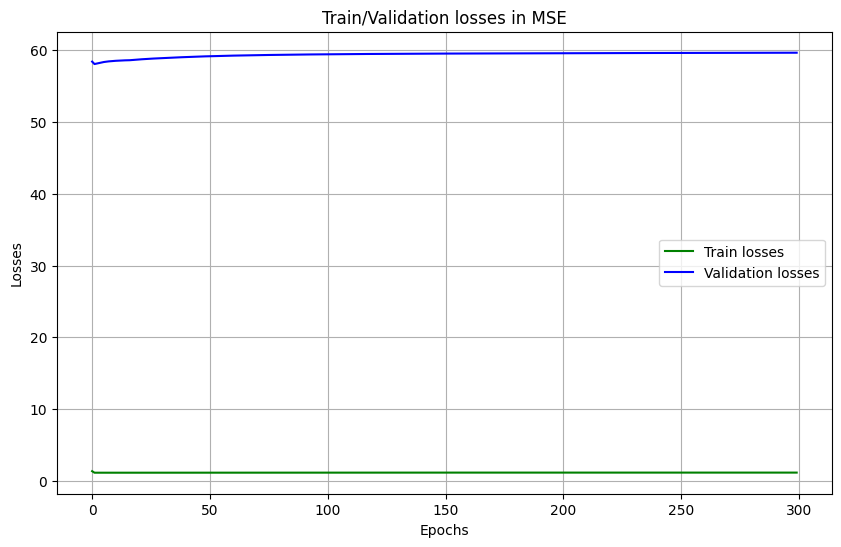

BO is [[1.65e+02 3.00e+01 1.00e-03 1.00e-03]], with validation loss of [56.97814235]
Next suggested query point by UCB: 70.000-2.000-0.001-0.001
[[5.00e+01 2.00e+00 5.00e-01 1.00e-02]
 [5.50e+01 2.00e+00 1.00e-03 1.00e-03]
 [6.00e+01 2.00e+00 1.00e-03 1.00e-03]
 [1.30e+02 2.00e+00 1.00e-03 1.00e-03]
 [2.00e+02 2.00e+00 1.00e-03 1.00e-03]
 [2.70e+02 2.00e+00 1.00e-03 1.00e-03]
 [1.65e+02 3.00e+01 9.99e-01 9.99e-01]
 [6.50e+01 2.00e+00 1.00e-03 1.00e-03]
 [2.35e+02 3.00e+01 9.99e-01 9.99e-01]
 [7.50e+01 2.00e+00 1.00e-03 1.00e-03]
 [3.00e+02 3.00e+01 9.99e-01 9.99e-01]
 [1.65e+02 3.00e+01 1.00e-03 1.00e-03]] [[ 34.81696765]
 [ 33.37847899]
 [ 33.71310823]
 [ 34.09909478]
 [ 34.55456865]
 [ 34.1593104 ]
 [  0.22893775]
 [ 34.64108571]
 [ 15.05886805]
 [ 34.78877624]
 [144.65054798]
 [ 56.97814235]]
Epoch [100/300], Loss: 0.41
Validation Loss: 39.33
Epoch [200/300], Loss: 0.19
Validation Loss: 33.64
Epoch [300/300], Loss: 0.04
Validation Loss: 33.34
Training completed in 122.66 seconds


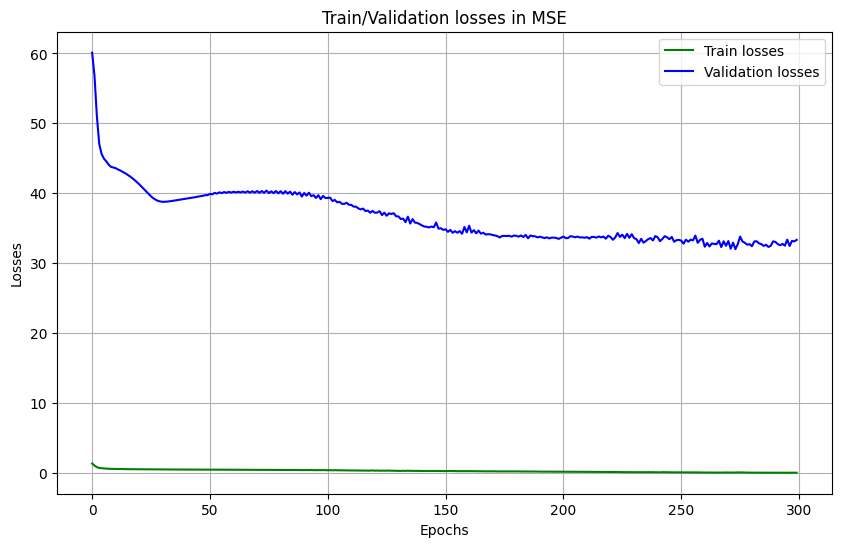

BO is [[7.e+01 2.e+00 1.e-03 1.e-03]], with validation loss of [31.9357884]
Next suggested query point by UCB: 80.000-2.000-0.001-0.001
[[5.00e+01 2.00e+00 5.00e-01 1.00e-02]
 [5.50e+01 2.00e+00 1.00e-03 1.00e-03]
 [6.00e+01 2.00e+00 1.00e-03 1.00e-03]
 [1.30e+02 2.00e+00 1.00e-03 1.00e-03]
 [2.00e+02 2.00e+00 1.00e-03 1.00e-03]
 [2.70e+02 2.00e+00 1.00e-03 1.00e-03]
 [1.65e+02 3.00e+01 9.99e-01 9.99e-01]
 [6.50e+01 2.00e+00 1.00e-03 1.00e-03]
 [2.35e+02 3.00e+01 9.99e-01 9.99e-01]
 [7.50e+01 2.00e+00 1.00e-03 1.00e-03]
 [3.00e+02 3.00e+01 9.99e-01 9.99e-01]
 [1.65e+02 3.00e+01 1.00e-03 1.00e-03]
 [7.00e+01 2.00e+00 1.00e-03 1.00e-03]] [[ 34.81696765]
 [ 33.37847899]
 [ 33.71310823]
 [ 34.09909478]
 [ 34.55456865]
 [ 34.1593104 ]
 [  0.22893775]
 [ 34.64108571]
 [ 15.05886805]
 [ 34.78877624]
 [144.65054798]
 [ 56.97814235]
 [ 31.9357884 ]]
Epoch [100/300], Loss: 0.44
Validation Loss: 39.50
Epoch [200/300], Loss: 0.20
Validation Loss: 34.89
Epoch [300/300], Loss: 0.04
Validation Loss: 

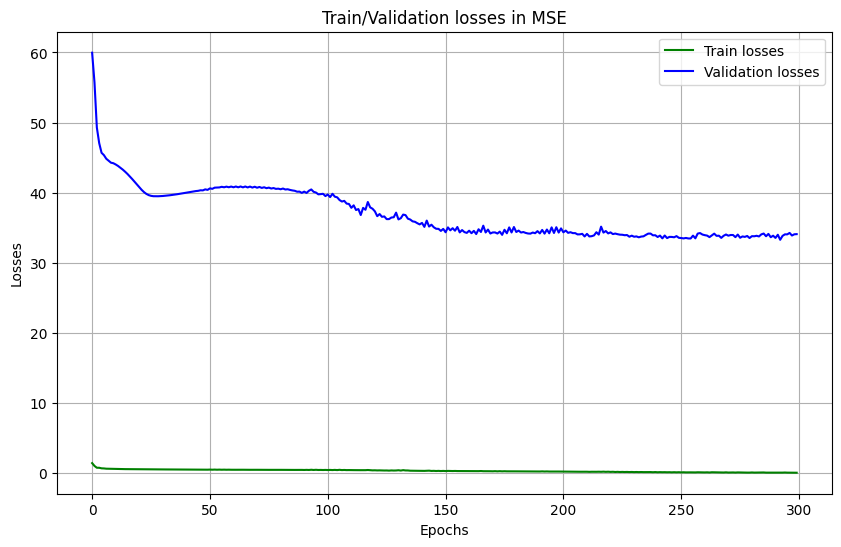

BO is [[8.e+01 2.e+00 1.e-03 1.e-03]], with validation loss of [33.22664306]
Next suggested query point by UCB: 85.000-2.000-0.001-0.001
[[5.00e+01 2.00e+00 5.00e-01 1.00e-02]
 [5.50e+01 2.00e+00 1.00e-03 1.00e-03]
 [6.00e+01 2.00e+00 1.00e-03 1.00e-03]
 [1.30e+02 2.00e+00 1.00e-03 1.00e-03]
 [2.00e+02 2.00e+00 1.00e-03 1.00e-03]
 [2.70e+02 2.00e+00 1.00e-03 1.00e-03]
 [1.65e+02 3.00e+01 9.99e-01 9.99e-01]
 [6.50e+01 2.00e+00 1.00e-03 1.00e-03]
 [2.35e+02 3.00e+01 9.99e-01 9.99e-01]
 [7.50e+01 2.00e+00 1.00e-03 1.00e-03]
 [3.00e+02 3.00e+01 9.99e-01 9.99e-01]
 [1.65e+02 3.00e+01 1.00e-03 1.00e-03]
 [7.00e+01 2.00e+00 1.00e-03 1.00e-03]
 [8.00e+01 2.00e+00 1.00e-03 1.00e-03]] [[ 34.81696765]
 [ 33.37847899]
 [ 33.71310823]
 [ 34.09909478]
 [ 34.55456865]
 [ 34.1593104 ]
 [  0.22893775]
 [ 34.64108571]
 [ 15.05886805]
 [ 34.78877624]
 [144.65054798]
 [ 56.97814235]
 [ 31.9357884 ]
 [ 33.22664306]]
Epoch [100/300], Loss: 0.42
Validation Loss: 40.77
Epoch [200/300], Loss: 0.20
Validation L

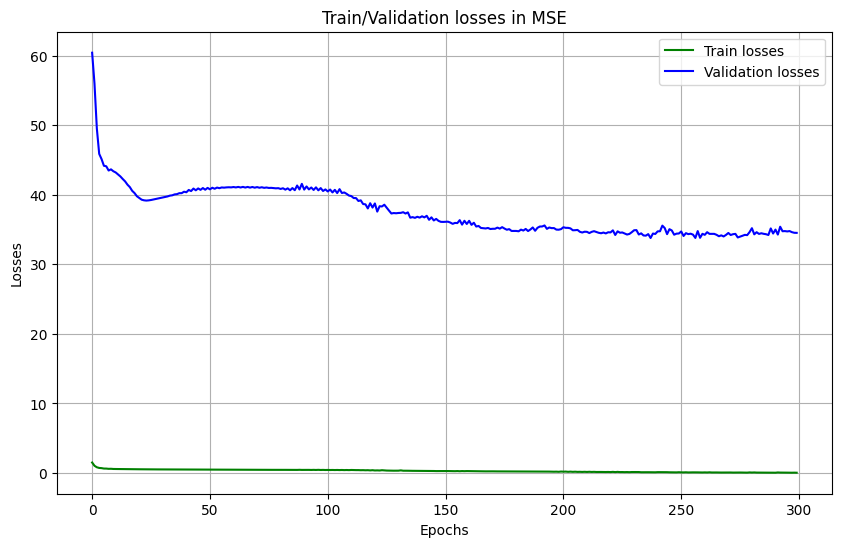

BO is [[8.5e+01 2.0e+00 1.0e-03 1.0e-03]], with validation loss of [33.68507598]
Next suggested query point by UCB: 90.000-2.000-0.001-0.001
[[5.00e+01 2.00e+00 5.00e-01 1.00e-02]
 [5.50e+01 2.00e+00 1.00e-03 1.00e-03]
 [6.00e+01 2.00e+00 1.00e-03 1.00e-03]
 [1.30e+02 2.00e+00 1.00e-03 1.00e-03]
 [2.00e+02 2.00e+00 1.00e-03 1.00e-03]
 [2.70e+02 2.00e+00 1.00e-03 1.00e-03]
 [1.65e+02 3.00e+01 9.99e-01 9.99e-01]
 [6.50e+01 2.00e+00 1.00e-03 1.00e-03]
 [2.35e+02 3.00e+01 9.99e-01 9.99e-01]
 [7.50e+01 2.00e+00 1.00e-03 1.00e-03]
 [3.00e+02 3.00e+01 9.99e-01 9.99e-01]
 [1.65e+02 3.00e+01 1.00e-03 1.00e-03]
 [7.00e+01 2.00e+00 1.00e-03 1.00e-03]
 [8.00e+01 2.00e+00 1.00e-03 1.00e-03]
 [8.50e+01 2.00e+00 1.00e-03 1.00e-03]] [[ 34.81696765]
 [ 33.37847899]
 [ 33.71310823]
 [ 34.09909478]
 [ 34.55456865]
 [ 34.1593104 ]
 [  0.22893775]
 [ 34.64108571]
 [ 15.05886805]
 [ 34.78877624]
 [144.65054798]
 [ 56.97814235]
 [ 31.9357884 ]
 [ 33.22664306]
 [ 33.68507598]]
Epoch [100/300], Loss: 0.42
Vali

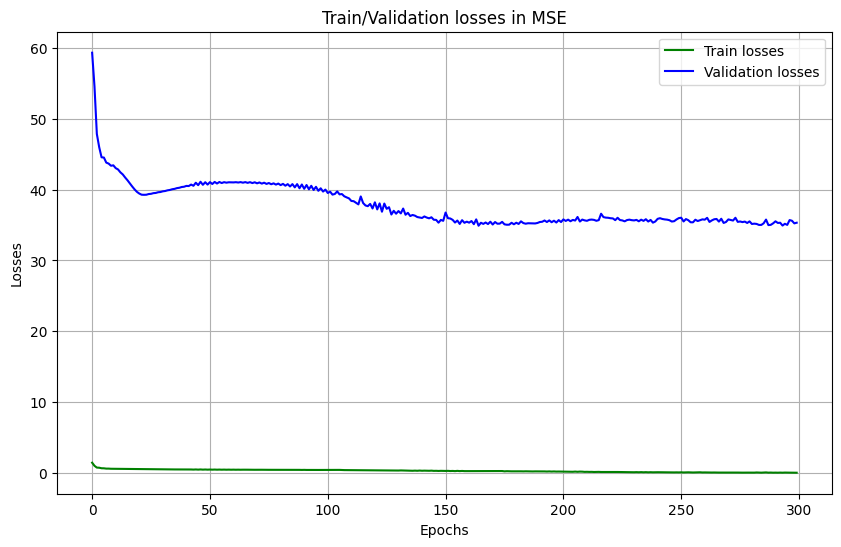

BO is [[9.e+01 2.e+00 1.e-03 1.e-03]], with validation loss of [34.64977767]
Next suggested query point by UCB: 95.000-2.000-0.001-0.001
[[5.00e+01 2.00e+00 5.00e-01 1.00e-02]
 [5.50e+01 2.00e+00 1.00e-03 1.00e-03]
 [6.00e+01 2.00e+00 1.00e-03 1.00e-03]
 [1.30e+02 2.00e+00 1.00e-03 1.00e-03]
 [2.00e+02 2.00e+00 1.00e-03 1.00e-03]
 [2.70e+02 2.00e+00 1.00e-03 1.00e-03]
 [1.65e+02 3.00e+01 9.99e-01 9.99e-01]
 [6.50e+01 2.00e+00 1.00e-03 1.00e-03]
 [2.35e+02 3.00e+01 9.99e-01 9.99e-01]
 [7.50e+01 2.00e+00 1.00e-03 1.00e-03]
 [3.00e+02 3.00e+01 9.99e-01 9.99e-01]
 [1.65e+02 3.00e+01 1.00e-03 1.00e-03]
 [7.00e+01 2.00e+00 1.00e-03 1.00e-03]
 [8.00e+01 2.00e+00 1.00e-03 1.00e-03]
 [8.50e+01 2.00e+00 1.00e-03 1.00e-03]
 [9.00e+01 2.00e+00 1.00e-03 1.00e-03]] [[ 34.81696765]
 [ 33.37847899]
 [ 33.71310823]
 [ 34.09909478]
 [ 34.55456865]
 [ 34.1593104 ]
 [  0.22893775]
 [ 34.64108571]
 [ 15.05886805]
 [ 34.78877624]
 [144.65054798]
 [ 56.97814235]
 [ 31.9357884 ]
 [ 33.22664306]
 [ 33.68507598

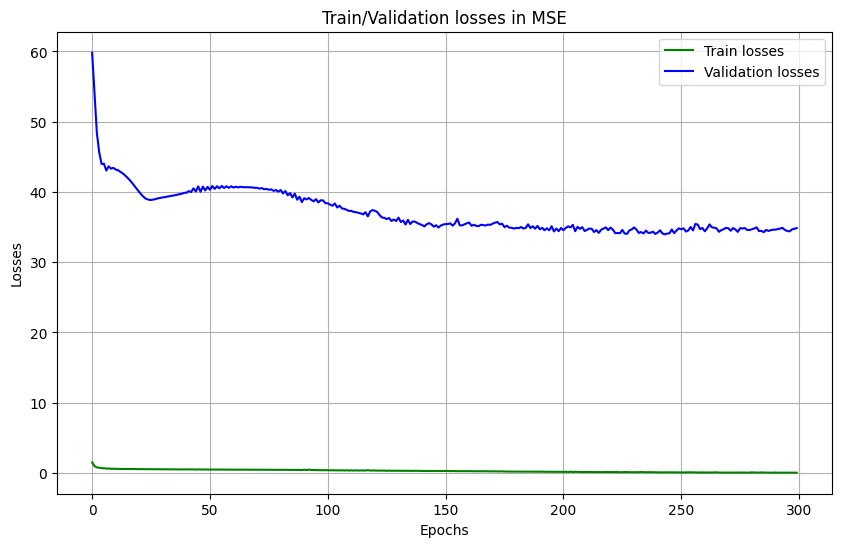

BO is [[9.5e+01 2.0e+00 1.0e-03 1.0e-03]], with validation loss of [33.88093327]
Next suggested query point by UCB: 100.000-2.000-0.001-0.001
[[5.00e+01 2.00e+00 5.00e-01 1.00e-02]
 [5.50e+01 2.00e+00 1.00e-03 1.00e-03]
 [6.00e+01 2.00e+00 1.00e-03 1.00e-03]
 [1.30e+02 2.00e+00 1.00e-03 1.00e-03]
 [2.00e+02 2.00e+00 1.00e-03 1.00e-03]
 [2.70e+02 2.00e+00 1.00e-03 1.00e-03]
 [1.65e+02 3.00e+01 9.99e-01 9.99e-01]
 [6.50e+01 2.00e+00 1.00e-03 1.00e-03]
 [2.35e+02 3.00e+01 9.99e-01 9.99e-01]
 [7.50e+01 2.00e+00 1.00e-03 1.00e-03]
 [3.00e+02 3.00e+01 9.99e-01 9.99e-01]
 [1.65e+02 3.00e+01 1.00e-03 1.00e-03]
 [7.00e+01 2.00e+00 1.00e-03 1.00e-03]
 [8.00e+01 2.00e+00 1.00e-03 1.00e-03]
 [8.50e+01 2.00e+00 1.00e-03 1.00e-03]
 [9.00e+01 2.00e+00 1.00e-03 1.00e-03]
 [9.50e+01 2.00e+00 1.00e-03 1.00e-03]] [[ 34.81696765]
 [ 33.37847899]
 [ 33.71310823]
 [ 34.09909478]
 [ 34.55456865]
 [ 34.1593104 ]
 [  0.22893775]
 [ 34.64108571]
 [ 15.05886805]
 [ 34.78877624]
 [144.65054798]
 [ 56.97814235]
 [

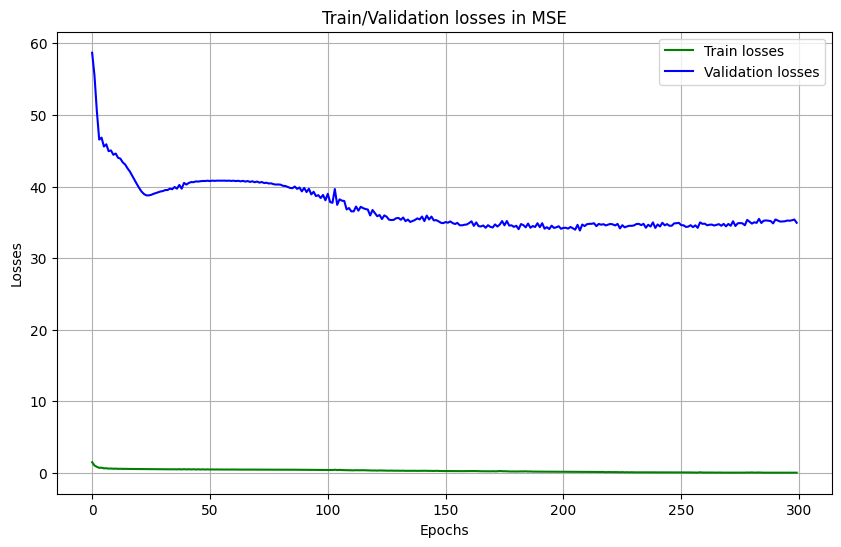

BO is [[1.e+02 2.e+00 1.e-03 1.e-03]], with validation loss of [33.72152256]
Next suggested query point by UCB: 105.000-2.000-0.001-0.001
[[5.00e+01 2.00e+00 5.00e-01 1.00e-02]
 [5.50e+01 2.00e+00 1.00e-03 1.00e-03]
 [6.00e+01 2.00e+00 1.00e-03 1.00e-03]
 [1.30e+02 2.00e+00 1.00e-03 1.00e-03]
 [2.00e+02 2.00e+00 1.00e-03 1.00e-03]
 [2.70e+02 2.00e+00 1.00e-03 1.00e-03]
 [1.65e+02 3.00e+01 9.99e-01 9.99e-01]
 [6.50e+01 2.00e+00 1.00e-03 1.00e-03]
 [2.35e+02 3.00e+01 9.99e-01 9.99e-01]
 [7.50e+01 2.00e+00 1.00e-03 1.00e-03]
 [3.00e+02 3.00e+01 9.99e-01 9.99e-01]
 [1.65e+02 3.00e+01 1.00e-03 1.00e-03]
 [7.00e+01 2.00e+00 1.00e-03 1.00e-03]
 [8.00e+01 2.00e+00 1.00e-03 1.00e-03]
 [8.50e+01 2.00e+00 1.00e-03 1.00e-03]
 [9.00e+01 2.00e+00 1.00e-03 1.00e-03]
 [9.50e+01 2.00e+00 1.00e-03 1.00e-03]
 [1.00e+02 2.00e+00 1.00e-03 1.00e-03]] [[ 34.81696765]
 [ 33.37847899]
 [ 33.71310823]
 [ 34.09909478]
 [ 34.55456865]
 [ 34.1593104 ]
 [  0.22893775]
 [ 34.64108571]
 [ 15.05886805]
 [ 34.78877624]

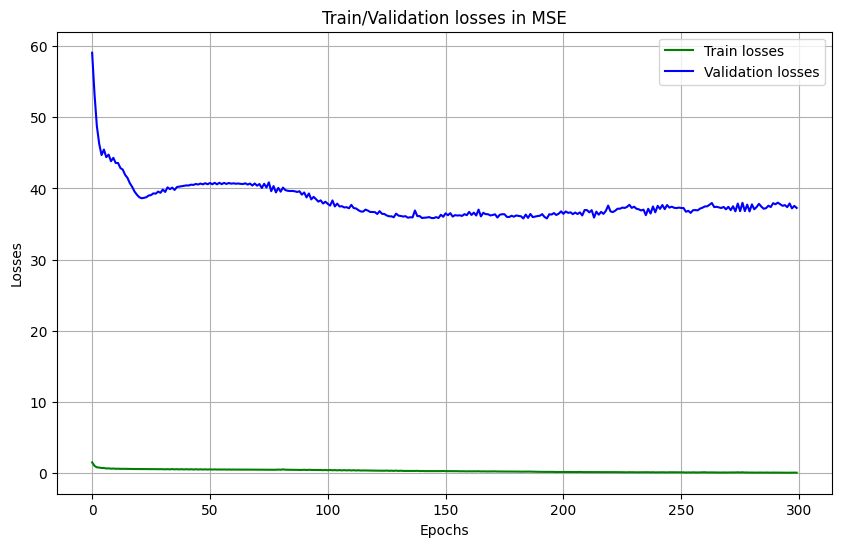

BO is [[1.05e+02 2.00e+00 1.00e-03 1.00e-03]], with validation loss of [35.57595516]
Next suggested query point by UCB: 110.000-2.000-0.001-0.001
[[5.00e+01 2.00e+00 5.00e-01 1.00e-02]
 [5.50e+01 2.00e+00 1.00e-03 1.00e-03]
 [6.00e+01 2.00e+00 1.00e-03 1.00e-03]
 [1.30e+02 2.00e+00 1.00e-03 1.00e-03]
 [2.00e+02 2.00e+00 1.00e-03 1.00e-03]
 [2.70e+02 2.00e+00 1.00e-03 1.00e-03]
 [1.65e+02 3.00e+01 9.99e-01 9.99e-01]
 [6.50e+01 2.00e+00 1.00e-03 1.00e-03]
 [2.35e+02 3.00e+01 9.99e-01 9.99e-01]
 [7.50e+01 2.00e+00 1.00e-03 1.00e-03]
 [3.00e+02 3.00e+01 9.99e-01 9.99e-01]
 [1.65e+02 3.00e+01 1.00e-03 1.00e-03]
 [7.00e+01 2.00e+00 1.00e-03 1.00e-03]
 [8.00e+01 2.00e+00 1.00e-03 1.00e-03]
 [8.50e+01 2.00e+00 1.00e-03 1.00e-03]
 [9.00e+01 2.00e+00 1.00e-03 1.00e-03]
 [9.50e+01 2.00e+00 1.00e-03 1.00e-03]
 [1.00e+02 2.00e+00 1.00e-03 1.00e-03]
 [1.05e+02 2.00e+00 1.00e-03 1.00e-03]] [[ 34.81696765]
 [ 33.37847899]
 [ 33.71310823]
 [ 34.09909478]
 [ 34.55456865]
 [ 34.1593104 ]
 [  0.22893775]


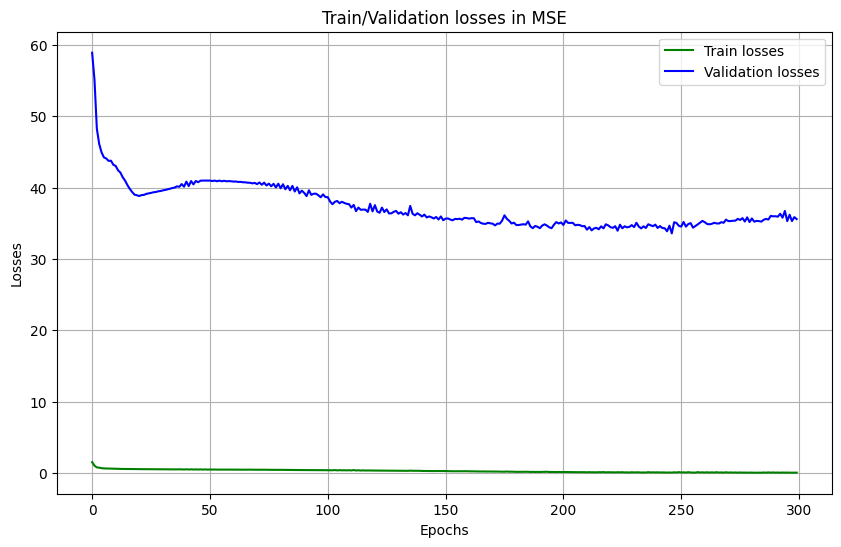

BO is [[1.1e+02 2.0e+00 1.0e-03 1.0e-03]], with validation loss of [33.54737858]
Next suggested query point by UCB: 115.000-2.000-0.001-0.001
[[5.00e+01 2.00e+00 5.00e-01 1.00e-02]
 [5.50e+01 2.00e+00 1.00e-03 1.00e-03]
 [6.00e+01 2.00e+00 1.00e-03 1.00e-03]
 [1.30e+02 2.00e+00 1.00e-03 1.00e-03]
 [2.00e+02 2.00e+00 1.00e-03 1.00e-03]
 [2.70e+02 2.00e+00 1.00e-03 1.00e-03]
 [1.65e+02 3.00e+01 9.99e-01 9.99e-01]
 [6.50e+01 2.00e+00 1.00e-03 1.00e-03]
 [2.35e+02 3.00e+01 9.99e-01 9.99e-01]
 [7.50e+01 2.00e+00 1.00e-03 1.00e-03]
 [3.00e+02 3.00e+01 9.99e-01 9.99e-01]
 [1.65e+02 3.00e+01 1.00e-03 1.00e-03]
 [7.00e+01 2.00e+00 1.00e-03 1.00e-03]
 [8.00e+01 2.00e+00 1.00e-03 1.00e-03]
 [8.50e+01 2.00e+00 1.00e-03 1.00e-03]
 [9.00e+01 2.00e+00 1.00e-03 1.00e-03]
 [9.50e+01 2.00e+00 1.00e-03 1.00e-03]
 [1.00e+02 2.00e+00 1.00e-03 1.00e-03]
 [1.05e+02 2.00e+00 1.00e-03 1.00e-03]
 [1.10e+02 2.00e+00 1.00e-03 1.00e-03]] [[ 34.81696765]
 [ 33.37847899]
 [ 33.71310823]
 [ 34.09909478]
 [ 34.5545686

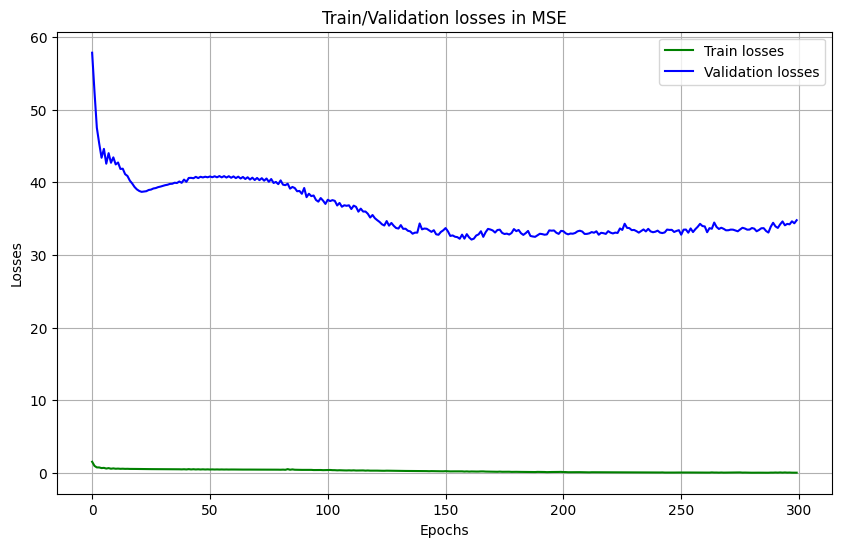

BO is [[1.15e+02 2.00e+00 1.00e-03 1.00e-03]], with validation loss of [31.92350645]


In [34]:
# Define the Gaussian Process surrogate model
noise_assumption = 1e-10
rbf_lengthscale = 0.1
beta = 1.96        # UCB exploration parameter. beta increases, exploration increases.
eta = 0.05         # PI exploration parameter. 0.1 for explore, 0.01 for exploitiation
xi = 0.1          # EI exploration parameter. 0.1  for balance, 0.01 for exploitiation

# Fit the Gaussian Process Regression model
kernel = RBF(length_scale=rbf_lengthscale*len(X.T))
bogp = GaussianProcessRegressor(kernel = kernel, alpha=noise_assumption, n_restarts_optimizer=5)

breakcount = 0

while breakcount < 20 :
    # Update the surrogate model with the new observation
    df_X, df_y = update_surrogate_model(query, obs)
    X = df_X
    Y = df_y
    
    # Fit the surrogate model with the given dataset
    bogp.fit(df_X, df_y)

    # # Get the next suggested query point
    next_query_point_ucb, af_ucb = upper_confidence_bound(beta)
    next_query_point_pi, af_pi = probability_improvement(eta)
    next_query_point_ei, af_ei = expected_improvement(xi)

    # # Comparing 3 aq. function and choose the highest.
    next_query_point, chosen_af = choose_next_query_point(next_query_point_ucb, af_ucb, next_query_point_ei, af_ei, next_query_point_pi, af_pi)

    print(f'Next suggested query point by {chosen_af}: '
          f'{np.round(next_query_point[0], 3):.3f}-'
          f'{np.round(next_query_point[1], 3):.3f}-'
          f'{np.round(next_query_point[2], 3):.3f}-'
          f'{np.round(next_query_point[3], 3):.3f}')
    print(df_X, df_y)
    bo = next_query_point #For bo hidden_dim, num_layers, dropout, learning_rate

    unscaled_test_targets, unscaled_test_predictions, train_score, val_score = main(train_loader, val_loader, test_loader, bo) 
    bo_train_score = pd.DataFrame(train_score)
    bo_val_score = pd.DataFrame(val_score)
    score = abs(bo_train_score - bo_val_score)
    min_score = score.min()

    query = np.array(bo).reshape(1, -1)
    obs = np.array(min_score) # val_loss # Validation loss
    
    print(f'BO is {query}, with validation loss of {obs}')
    
    breakcount +=1


In [45]:
y_min = np.argmin(Y)
x_min = X[y_min]
bo = x_min

Epoch [100/300], Loss: 29.96
Validation Loss: 8.10
Epoch [200/300], Loss: 29.88
Validation Loss: 8.12
Epoch [300/300], Loss: 29.86
Validation Loss: 8.12
Training completed in 5604.74 seconds


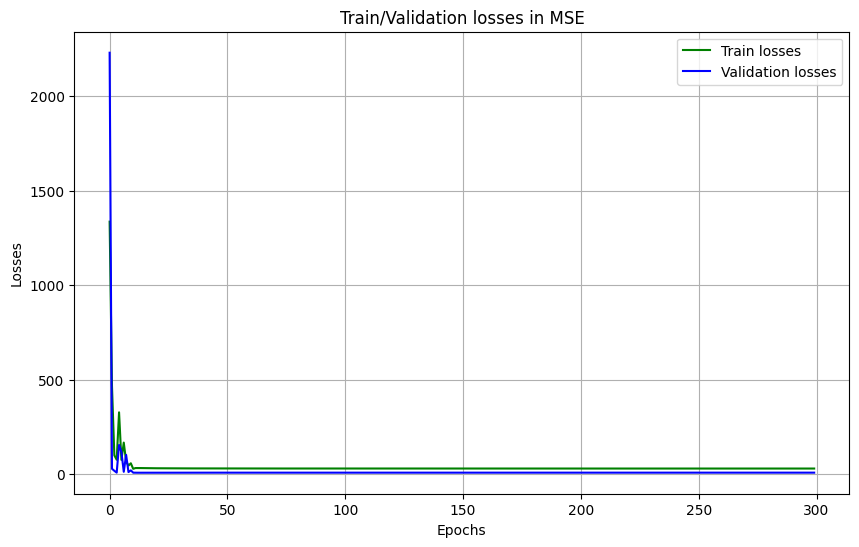

In [46]:
if __name__ == '__main__':
#     bo = [50, 2, 0.5, 0.01] # Call BO.
    unscaled_test_targets, unscaled_test_predictions, train_score, val_score = main(train_loader, val_loader, test_loader, bo) 

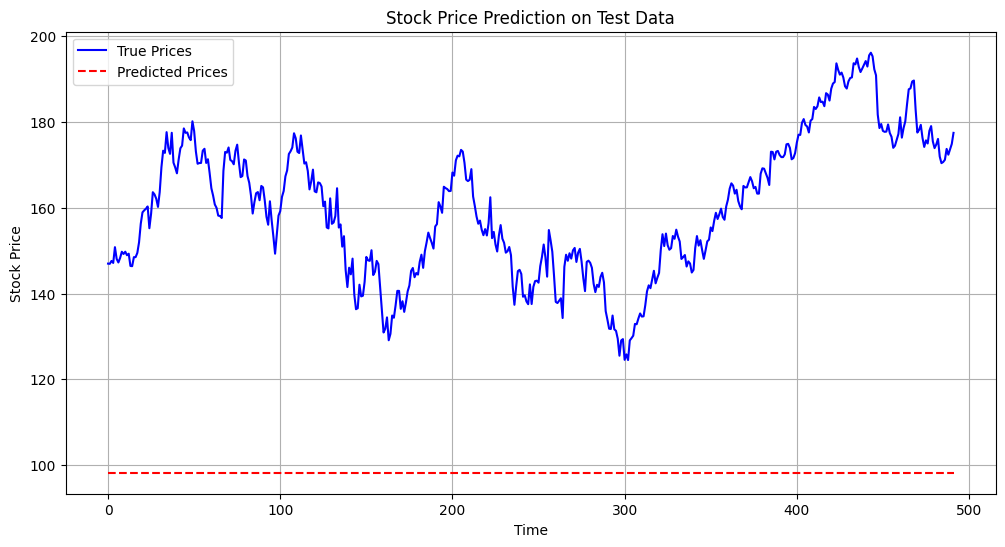

In [47]:
plt.figure(figsize=(12, 6))
plt.plot(unscaled_test_targets, label='True Prices', color='blue')
plt.plot(unscaled_test_predictions, label='Predicted Prices', color='red', linestyle='dashed')

plt.title('Stock Price Prediction on Test Data')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

Conclusion

One question comes to mind when predicting stock market. Is stock price a causation or consequence? 

This project doesn't consider...
1. Transaction cost
2. Slippage
3. 